In [2]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import scipy as sp

from tqdm import tqdm
import matplotlib.pyplot as plt


import sys
import os
sys.path.append('../')
sys.path.append('../power_law_rf')
import optimizers
from power_law_rf.power_law_rf import PowerLawRF
from power_law_rf.ode import ode_resolvent_log_implicit_full
from power_law_rf.ode import DanaHparams
from power_law_rf.ode import ODEInputs
from power_law_rf.least_squares import lsq_streaming_optax_simple
import power_law_rf.deterministic_equivalent as theory

key = random.PRNGKey(0)

In [14]:
import importlib
importlib.reload(theory)

<module 'power_law_rf.deterministic_equivalent' from '/Users/paquette.30/Documents/Experimental/colabs/../power_law_rf/deterministic_equivalent.py'>

In [3]:
ALPHA = 1.0
BETA = 0.7
V = 2000
D = 500
SGDBATCH=1
STEPS = 10**6

In [4]:
key, subkey = random.split(key)
problem = PowerLawRF.initialize_random(alpha=ALPHA, beta=BETA, v=V, d=D, key=subkey)


In [5]:
g1 = optimizers.powerlaw_schedule(1.0, 0.0, 0.0, 1)
g2 = optimizers.powerlaw_schedule(0.5/problem.population_trace, 0.0, 0.0, 1)
g3 = optimizers.powerlaw_schedule(1.0/problem.population_trace, 0.0, -1.0/(2*problem.alpha), 1)
Delta = optimizers.powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(problem.alpha+problem.beta)/(2*problem.alpha))
danadecayopt = optimizers.dana_optimizer(g1=g1,g2=g2,g3=g3,Delta=Delta)
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
danadecaytimes,danadecaylosses = lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         danadecayopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:33<00:00,  1.39it/s]


In [8]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
rho_init = problem.get_rhos()
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

Keigs = problem.get_hessian_spectra()
riskInftyTheory=problem.get_theory_limit_loss()

Dt = 10**(-2)

odeTimes_dana_decay2, odeRisks_dana_decay2 = ode_resolvent_log_implicit_full(
    ODEInputs(Keigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory),
    DanaHparams(g1, g2, g3, Delta),
    SGDBATCH, problem.d, STEPS, Dt)


In [15]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

fake_eigs,rho_init = theory.theory_rhos(problem.alpha,problem.beta,problem.d)
riskInftyTheory=problem.get_theory_limit_loss()

Dt = 10**(-2)

odeTimes_dana_decay3, odeRisks_dana_decay3 = ode_resolvent_log_implicit_full(
    ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
    DanaHparams(g1, g2, g3, Delta),
    SGDBATCH, problem.d, STEPS, Dt)

In [15]:

# #Compute the theoretical limiting loss value
# riskInftyTheory = theory.theory_limit_loss(ALPHA, BETA, V, D)
# print('Theoretical limiting loss value is {}'.format(riskInftyTheory))

# # Compute theoretical integrals using density approximation
# lower_bound = theory.theory_lambda_min(ALPHA)*(D**(-2*ALPHA)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha)) #tt_lmin(alpha)*(D**(-2*alpha)) #jnp.minimum(0.00001, 0.9*(D+1)**(-2.0*alpha))
# upper_bound = 1.0*1.1


# fake_eigs = jnp.power(jnp.arange(1,D+1,dtype=jnp.float32),-2.0*ALPHA)
# b_values = fake_eigs - 0.5 * jnp.diff(fake_eigs, prepend = upper_bound)
# a_values = fake_eigs + 0.5 * jnp.diff(fake_eigs, append = lower_bound)


# num_splits = 5
# rho_weights = problem.get_theory_rho_weights(num_splits, a_values, b_values)

# print('Initial loss value is is {}'.format(jnp.sum( rho_weights*fake_eigs) + riskInftyTheory))


# rho_init = rho_weights #density * dx
# num_grid_points = D
# sigma_init = jnp.zeros(num_grid_points, dtype=jnp.float32)
# chi_init = jnp.zeros(num_grid_points, dtype=jnp.float32)

# Dt = 10**(-2) #10**(-2)


# odeTimes_dana_decay_theory, odeRisks_dana_decay_theory = ode_resolvent_log_implicit_full(
#     ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
#     DanaHparams(g1, g2, g3, Delta),
#     SGDBATCH, num_grid_points, STEPS, Dt)

Theoretical limiting loss value is 2.2151913071866147e-05


TypeError: 'int' object is not callable

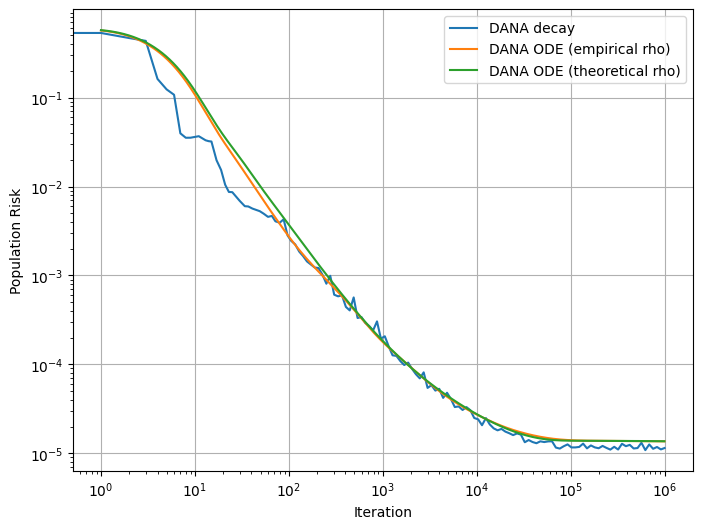

In [16]:
plt.figure(figsize=(8,6))
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(odeTimes_dana_decay2, odeRisks_dana_decay2, label='DANA ODE (empirical rho)')
plt.loglog(odeTimes_dana_decay3, odeRisks_dana_decay3, label='DANA ODE (theoretical rho)')
plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)

In [9]:
adamopt = optax.adam(learning_rate=0.01)
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
adamtimes,adamlosses = lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         adamopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:11<00:00,  1.82it/s]


In [20]:
step_lengths = []
current_steps = 1000
while current_steps <= STEPS:
    step_lengths.append(current_steps)
    current_steps *= 2

adam_cos_decay_results = []
for steps in tqdm(step_lengths):
    cos_decay = optax.cosine_decay_schedule(init_value=0.01, decay_steps=steps)
    adam_cos_decay = optax.adam(learning_rate=cos_decay)
    key, newkey = random.split(key)
    times, losses = lsq_streaming_optax_simple(newkey,
                         problem.get_data,
                         SGDBATCH,
                         steps,
                         adam_cos_decay,
                         jnp.zeros((problem.d,1)),
                         problem.get_population_risk)
    adam_cos_decay_results.append((times, losses))

100%|██████████| 10/10 [02:10<00:00, 13.05s/it]


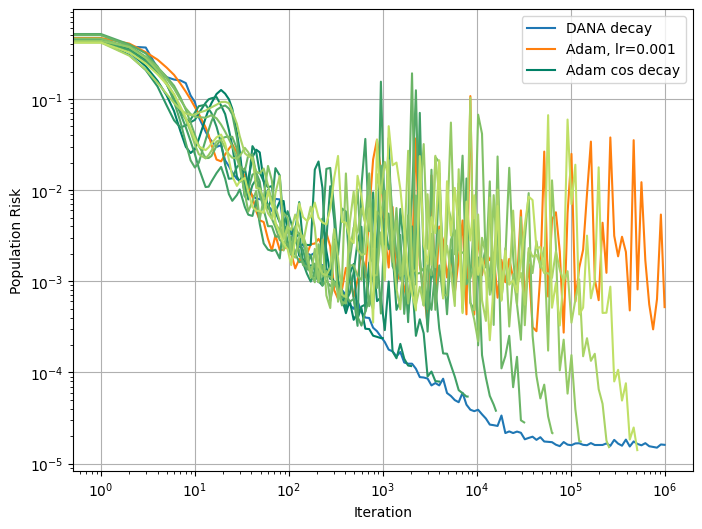

In [32]:
plt.figure(figsize=(8,6))
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(adamtimes,adamlosses,label='Adam, lr=0.001')
import matplotlib.cm as cm
colors = cm.summer(jnp.linspace(0, 0.75, len(adam_cos_decay_results)))
for (times, losses), color in zip(adam_cos_decay_results, colors):
    if jnp.array_equal(color, colors[0]):
        plt.loglog(times, losses, color=color, label='Adam cos decay')
    else:
        plt.loglog(times, losses, color=color)

plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)
plt.savefig('adam_cos_decay.pdf')